In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from scipy.sparse import vstack
import itertools as it
from pprint import pprint
from tqdm import tqdm
from time import time

from IPython.display import Audio

plt.style.use('fivethirtyeight')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import confusion_matrix, classification_report, make_scorer, recall_score, precision_score
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.linear_model import LogisticRegression, Perceptron
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier, GradientBoostingClassifier
from sklearn.ensemble import BaggingClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
import random

In [4]:
# read in the saved dataframe
whole_frame = pd.read_csv('whole_frame.csv', index_col='Unnamed: 0')
whole_frame.head()

,artist,lyrics,coast
0,Cappadonna,well now you always seemed so brave before wha...,east
1,Cappadonna,red dog ebonies half gotti and lebanese you se...,east
2,Cappadonna,where you going arent you scared well get you ...,east
3,Cappadonna,yo break that dutch down you and your man yall...,east
4,Cappadonna,repeating in background rock the body body ro...,east


***Naive Train-test split:***

As discussed in the README file, a standard train-test-split on the data is the wrong way of going about this problem. While the resulting accuracy scores are high, the scores are not indicative of how the model truly performs in terms of the task of dialect identification, and applying the model to unseen rappers would yield lower scores.

In [5]:
# target = coast ; predictors = lyrics (will vectorize later)
y = whole_frame.coast
X = whole_frame.lyrics

In [91]:
y.shape, X.shape

((2691,), (2691,))

In [99]:
# standard train-test-split, stratifying on y. Each rapper will (probably) have tracks in both the train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2152,), (539,), (2152,), (539,))

In [100]:
# using the TfidfVectorizer to translate the raw lyrics into predictors.
vect = TfidfVectorizer(stop_words=s)
vect = vect.fit(X_train)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'skee', 'smif', 'wessun'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [101]:
# using a standard LogisticRegression.
model = LogisticRegression()
model.fit(X_train, y_train)
print('train score: ', model.score(X_train, y_train))
print('test score: ', model.score(X_test, y_test))
scores = cross_val_score(model, X_train, y_train, cv=5)
print('cross val scores mean: ', scores.mean())

train score:  0.9400557620817844
test score:  0.8367346938775511
cross val scores mean:  0.8094803863378838


Accuracy scores are already quite high with just a standard Logistic Regression model.

***HONEST TRAIN-TEST SPLIT***

Now, as discussed in the README file, I set up the functions necessary to model using a train-test-split which splits on rappers, as opposed to treating all songs from the west coast as independent entries.

In [6]:
# form two dataframes: one for each coast.
east_artists = whole_frame[whole_frame.coast == 'east'].artist.unique()
west_artists = whole_frame[whole_frame.coast == 'west'].artist.unique()

In [7]:
# Class imbalance.
whole_frame.coast.value_counts(normalize=True)

east    0.56171
west    0.43829
Name: coast, dtype: float64

In [9]:
def artist_train_test_split(frame=whole_frame, random_state=1):
    """Custom train-test-split to split on rappers, stratifying on y"""

    # set the random state
    random.seed(random_state)
    
    X_test = []
    y_test = []

    # this ratio is used as a basis for choosing which class to select a rapper from in the cumulative filling of the 
    # test set.
    east_ratio = 0.561873

    east = list(east_artists).copy()
    west = list(west_artists).copy()

    
    while len(X_test) < 0.25*len(whole_frame): # loop will break when the test set is of the right size

        if east_ratio <= 0.57: # which coast to randomly (according to random state) choose a rapper from
            artist = random.sample(east, 1)[0] # randomly select rapper from east coast rappers
            east.remove(artist) # we are randomly choosing without replacement, so drop rapper name.
            ext = list(whole_frame[whole_frame.artist == artist].lyrics.values) # songs to extend test set with
            y_test.extend(['east']*len(whole_frame[whole_frame.artist == artist])) # extend target test set
            
        else: # same, for west coast
            artist = random.sample(west, 1)[0]
            west.remove(artist)
            ext = list(whole_frame[whole_frame.artist == artist].lyrics.values)
            y_test.extend(['west']*len(whole_frame[whole_frame.artist == artist]))

        X_test.extend(ext) # extend predictor set
        east_ratio = np.mean([y == 'east' for y in y_test]) # ratio of east songs in the test set.To compare with 0.56

    X_train = []
    y_train = []
    train_artists = []

    # then, fill the training set with the remaining rappers' songs
    for artist in east:
        add = list(whole_frame[whole_frame.artist == artist].lyrics)
        X_train.extend(add)
        y_train.extend(['east']*len(add))
        train_artists.extend([artist]*len(add))

    for artist in west:
        add = list(whole_frame[whole_frame.artist == artist].lyrics)
        X_train.extend(add)
        y_train.extend(['west']*len(add))
        train_artists.extend([artist]*len(add))
        
    
        
    return X_train, X_test, y_train, y_test, train_artists

***CROSS-VAL FUNCTION***

The custom method for splitting the data also has to be incorporated in the cross-validation scores function. 

This function takes as inputs the model (estimator) for the fitting; the training predictors set (in sparse format, i.e. already vectorized); the training target set; crucially, the list of rappers which are in the training set in order to randomly select from them in constructing the folds; the number of folds; the random state for the splitting.

In [9]:
def artist_cross_val_score(model, X_train_sparse, y_train, train_artists, n_splits=5, random_state=10):
    """Custom cross-validation score function"""
    
    # set the random state
    random.seed(random_state)
    
    ##### setting up the folds ######
    
    frame = pd.DataFrame([train_artists, y_train], index=['artist', 'coast']).T
    
    folds = {}
    
    east = list(frame[frame.coast == 'east'].artist.unique())
    west = list(frame[frame.coast == 'west'].artist.unique())

    tr_artists = train_artists.copy()
    
    i = n_splits
    while i > 0: #loop will break when all of the i folds have been constructed
        
        X_test = X_train_sparse[:0] # empty sparse matrix
        y_test = []

        east_ratio = 0.561873
        tr_length = len(tr_artists)

        while X_test.shape[0] < tr_length*(1/i): # loop will break when enough rappers have been added to the fold

            if east_ratio <= 0.57: # determines which coast the next rapper to be appended to the fold will be from
                
                # Adding the rows corresponding to the songs of the randomly selected rapper to the fold (X_test).
                # Adding the target variable ('west'/'east') to the fold (y_test).
                # Removing those entries from the inputted data (which is used going forward for filling folds).
                try:
                    artist = random.sample(east, 1)[0]
                    east.remove(artist)
                    while artist in tr_artists:
                        tr_artists.remove(artist)
                    slice_rows = list(frame[frame.artist == artist].index)
                    X_test = vstack((X_test, X_train_sparse[slice_rows[0]:slice_rows[-1]+1]))
                    y_test.extend(['east']*len(frame[frame.artist == artist]))
                except: # this except clause is triggered when there are no more rappers in the list of east rappers.
                    artist = random.sample(west, 1)[0]
                    west.remove(artist)
                    while artist in tr_artists:
                        tr_artists.remove(artist)
                    slice_rows = list(frame[frame.artist == artist].index)
                    X_test = vstack((X_test, X_train_sparse[slice_rows[0]:slice_rows[-1]+1]))
                    y_test.extend(['west']*len(frame[frame.artist == artist]))
                    
            else:
                try:
                    artist = random.sample(west, 1)[0]
                    west.remove(artist)
                    while artist in tr_artists:
                        tr_artists.remove(artist)
                    slice_rows = list(frame[frame.artist == artist].index)
                    X_test = vstack((X_test, X_train_sparse[slice_rows[0]:slice_rows[-1]+1]))
                    y_test.extend(['west']*len(frame[frame.artist == artist]))
                except:
                    artist = random.sample(east, 1)[0]
                    east.remove(artist)
                    while artist in tr_artists:
                        tr_artists.remove(artist)
                    slice_rows = list(frame[frame.artist == artist].index)
                    X_test = vstack((X_test, X_train_sparse[slice_rows[0]:slice_rows[-1]+1]))
                    y_test.extend(['east']*len(frame[frame.artist == artist]))

            east_ratio = np.mean([y == 'east' for y in y_test]) # update the ratio of east rappers in the fold.
            
            
        # enter the fold data into the dictionary.
        folds['fold_{}'.format(i)] = {'X':None, 'y':None}
        folds['fold_{}'.format(i)]['X'] = X_test
        folds['fold_{}'.format(i)]['y'] = y_test
        
        i -= 1 # one less fold left. The loop continues.
    
    
    
    ##### Getting the scores for each train-test fold combination (there are n_splits combinations) #####
    
    scores = []

    for fold in folds:
        # test set is the fold in the iteration
        X_test = folds[fold]['X']
        y_test = folds[fold]['y']
        
        # train set is all other folds
        other_folds = list(folds.keys())
        other_folds.remove(fold)
        X_train = X_test[:0]
        y_train = []
        
        for f in other_folds:
            X_train = vstack((X_train, folds[f]['X']))
            y_train.extend(folds[f]['y'])
        
        # get the scores
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))


    return scores

In [4]:
# reading in the stopwords compiled in other documents.
stopwords_full = pd.read_csv('stopwords_full')

***CUSTOM GRIDSEARCH CV:***

***PREPARING THE GRIDSEARCH: Defining all the potential models, vectorizers, lemmatizers, stemmers:***

I set up a function which uses inputs to make the selection of vectorizer, stemmer, and estimators to include in a score evaluation more simple to use.

The following functions are used within that main function, which is defined afterwards.

In [14]:
# selection of estimators
def get_models(model_dict):
    models = []
    m_dict = model_dict.copy()
    models_input_1 = None
    while models_input_1 not in ['', 'no']:
        a = True
        while a:
            print('Model class?')
            models_input_1 = input(f'Options:{list(m_dict.keys())}')
            to_append = []
            try:
                to_append.extend(m_dict[models_input_1])
                a = False
            except:
                try:
                    to_append.append(m_dict[models_input_1])
                    a = False
                except:
                    continue
            print('\n')
            
        
        print('these models are to be appended:')
        print(to_append)
        to_drop = input('do you want to drop any of these? Enter the indices: ')
        try:
            to_append.pop(int(to_drop))
        except:
            pass
        for item in to_append:
            models.append(item)
        print('\n')
        print('models to use:')
        print(models)
        print('\n')
        models_input_1 = input('do you want to add any more models?')
        print('\n')
    
    return models

In [15]:
# selection of vecctorizers
def get_vectorizers_and_keys(vect_dict):
    vectorizers = []
    vectorizers_keys = []
    v_dict = vect_dict.copy()
    vect_input_1 = None
    while vect_input_1 not in ['', 'no']:
        a = True
        while a:
            print('Which vectorizer?')
            vect_input_1 = input(f'Options:{list(v_dict.keys())}')
            to_append_values = []
            to_append_keys = []
            try:
                to_append_values.extend(list(v_dict[vect_input_1].values()))
                to_append_keys.extend(list(v_dict[vect_input_1].keys()))
                a = False
            except:
                try:
                    to_append_values.append(v_dict[vect_input_1])
                    to_append_keys.append(v_dict[vect_input_1])
                    a = False
                except:
                    continue
        
        print('\n')
        b = True
        while b:
            print('these vectorizers are to be appended:')
            print(to_append_keys)
            to_drop = input('do you want to drop any of these? Enter an index or hit enter for none: ')
            try:
                to_append_values.pop(int(to_drop))
                to_append_keys.pop(int(to_drop))
            except:
                b = False
            
        print(len(to_append_values))
        for item in to_append_values:
            vectorizers.append(item)
        print(len(vectorizers))
        for item in to_append_keys:
            vectorizers_keys.append(item)
        print('\n')
        print('vectorizers to use:')
        print(vectorizers_keys)
        print('\n')
        vect_input_1 = input('do you want to add any more vectorizers?')
        print('\n')
        
    if len(vectorizers) == 1:
        return vectorizers, ['vec']
    
    else:
        return vectorizers, vectorizers_keys

In [16]:
# selection of stemmers
def get_stemmers(stem_dict):
    stemmers = []
    s_dict = stem_dict.copy()
    stemmers_input_1 = None
    while stemmers_input_1 not in ['', 'no']:
        a = True
        while a:
            print('Which stemmer?')
            stemmers_input_1 = input(f'Options:{list(s_dict.keys())}')
            to_append = []
            try:
                to_append.append(s_dict[stemmers_input_1])
                a = False
            except:
                continue
            print('\n')
        
        for item in to_append:
            stemmers.append(item)
        print('\n')
        print('stemmers to use:')
        print(stemmers)
        print('\n')
        stemmers_input_1 = input('do you want to add any more stemmers?')
        print('\n')
    
    return stemmers

In [17]:
### this is the main function used for evaluation.
def custom_gridsearch_pipeline(model_dict, vect_dict, stem_dict, rand=10):

    ### Which configuration to GridSearch?
    models = get_models(model_dict)
    stemmers = get_stemmers(stem_dict)
    vectorizers, vectorizers_keys = get_vectorizers_and_keys(vect_dict)
    
    count = 0
    n_iter = len(models)*len(vectorizers)*len(stemmers)
    global scores_frame
    scores_frame = {}

    X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=rand)
    # maybe best to not have this within this function...

    # stemming:
    for stemmer in stemmers:

        ## vectorizer stage: (vectorizer chosen as cvec)
        for i in range(len(vectorizers)):
            vect = vectorizers[i]
            vect_key = vectorizers_keys[i]

            ## modelling stage:
            for model in models:
                
                if stemmer == None:
                    X_tr = X_train
                    X_te = X_test

                else:
                    X_tr = pd.Series(X_train).apply(lambda x: ' '.join([stemmer.stem(word) 
                                                                        for word in x.split()])).values
                    X_te = pd.Series(X_test).apply(lambda x: ' '.join([stemmer.stem(word) 
                                                                       for word in x.split()])).values

                X_tr = vect.fit_transform(X_tr)
                X_te = vect.transform(X_te)


                model.fit(X_tr, y_train)
                train = model.score(X_tr, y_train)
                test = model.score(X_te, y_test)
                cv = artist_cross_val_score(model, X_tr, y_train, train_artists)

                index = f'{model}; {vect_key}, stemmer:{stemmer}'
                scores_frame[index] = {}
                scores_frame[index]['train score'] = train
                scores_frame[index]['test score'] = test
                scores_frame[index]['cv scores mean'] = np.mean(cv)

                count += 1
                print(f'{count}/{n_iter} iterations complete')

    return pd.DataFrame(scores_frame).T#.sort_values('cv scores mean', ascending=False)

***SAME BUT WITH MULTIPLE RANDOM STATES:***

In [20]:
### another function for evaluating combinations of stemmers, vectorizers and estimators.
# This function uses three random states for the data splitting, due to the non-trivial variability in scores across
# random states.
def custom_gridsearch_random_states(model_dict, vect_dict, stem_dict, rands=[10,20,30]):

    ### Which configuration to GridSearch?
    models = get_models(model_dict)
    stemmers = get_stemmers(stem_dict)
    vectorizers, vectorizers_keys = get_vectorizers_and_keys(vect_dict)
    
    n_iter = len(rands)
    global scores_frame
    scores_frame = {}

    # stemming:
    for stemmer in stemmers:

        ## vectorizer stage: (vectorizer chosen as cvec)
        for i in range(len(vectorizers)):
            vect = vectorizers[i]
            vect_key = vectorizers_keys[i]

            ## modelling stage:
            for model in tqdm(models):
                    
                rand_scores = [[], [], []]
                count = 0
                for rand in rands:
                    
                    start = time()
                    X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=rand)

                    if stemmer == None:
                        X_tr = X_train
                        X_te = X_test

                    else:
                        X_tr = pd.Series(X_train).apply(lambda x: ' '.join([stemmer.stem(word) 
                                                                            for word in x.split()])).values
                        X_te = pd.Series(X_test).apply(lambda x: ' '.join([stemmer.stem(word) 
                                                                           for word in x.split()])).values

                    X_tr = vect.fit_transform(X_tr)
                    X_te = vect.transform(X_te)


                    model.fit(X_tr, y_train)
                    train = model.score(X_tr, y_train)
                    test = model.score(X_te, y_test)
                    cv = artist_cross_val_score(model, X_tr, y_train, train_artists, random_state=rand)
                    
                    rand_scores[0].append(train)
                    rand_scores[1].append(test)
                    rand_scores[2].append(np.mean(cv))
                    
                    count+=1
                    print(f'{count}/{n_iter} iterations complete. Time elapsed: {time() - start}')
                    
                 

                index = f'{model}; {vect_key}, stemmer:{stemmer}'
                scores_frame[index] = {}
                scores_frame[index]['mean train score'] = np.mean(rand_scores[0])
                scores_frame[index]['mean test score'] = np.mean(rand_scores[1])
                scores_frame[index]['mean cv scores mean'] = np.mean(rand_scores[2])

                count += 1
                

    return pd.DataFrame(scores_frame).T#.sort_values('cv scores mean', ascending=False)

Here, I establish all the stemmers, vectorizers, and estimators which will be evaluated. For each hyperparameter combination within an estimater / vectorizer, I add this model to a dictionary containing models to evaluate.

In [63]:
# STEMMERS
main_stemmers_dict = {'none':None, 'porter':PorterStemmer(), 'snowball':SnowballStemmer('english')}



# VECTORIZERS
main_vectorizers_dict = {}

cvec = {} # has to stay in a sub_dict just for the sake of cleaner indexing
for ng in [(1,1), (1,2), (1,3), (1,4), (2,4)]:
    cvec[f'cvec(ngram_range={ng})'] = CountVectorizer(stop_words=stopwords_full, ngram_range=ng)

    
tf_idf = {}
for max_df_ in np.linspace(0.01, 1, 40):
    for max_features_ in [1000, 5000, 10000, None]:
        tf_idf[f'tf_idf(max_df={max_df_})'] = TfidfVectorizer(stop_words=stopwords_full, # sublinear_tf=True,
                                      max_df=max_df_,
                                      max_features=max_features_,
                                      norm='l2')

#main_vectorizers_dict['cvec'] = cvec
#main_vectorizers_dict['tf_idf'] = tf_idf
main_vectorizers_dict['tf_idf'] = TfidfVectorizer(stop_words=stopwords_full, max_df=0.3104)





#MODELS
main_models_dict = {}

# Logistic Regression models:
lr_models = []
#for l1_ratio_ in np.linspace(0.01, 1, 20):
lr_models.append(LogisticRegression(penalty='elasticnet', solver='saga', l1_ratio=0.01,
                                        max_iter=10000))
# KNN models:
knn_models = []
for n_neighbors_ in range(200,250):
    knn_models.append(KNeighborsClassifier(n_neighbors=n_neighbors_))
    

# Bagging Classifier:
bag_models = []
for n_est in list(range(100,130,5)):
    bag_models.append(BaggingClassifier(base_estimator=DecisionTreeClassifier(), # need to experiment with DTC params
                       n_estimators=n_est,
                       max_features=0.3,
                       max_samples=0.5,
                     random_state=1)) # these are gonna be good.

# RandomForest models:
forest_models = []
for n in [100]:
    forest_models.append(RandomForestClassifier(random_state=1, n_estimators=n, max_features=1.0))
    
# AdaBoost models:
ada_models = []
for n in list(range(120,300,20)):
    ada_models.append(AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                           n_estimators=n,
                           random_state=1, algorithm='SAMME'))

# GradientBoosting models:
grad_boost_models = []
for n in range(70,150,20):
    grad_boost_models.append(GradientBoostingClassifier(n_estimators=n, learning_rate=0.2))
        
# SVC models:
svc_models = []
for c in [1]:
    for kern in ['rbf', 'linear']:
        svc_models.append(SVC(C=c, kernel=kern))
    
main_models_dict['lr'] = lr_models
main_models_dict['knn'] = knn_models
main_models_dict['bag'] = bag_models
main_models_dict['forest'] = forest_models
main_models_dict['ada'] = ada_models
main_models_dict['grad'] = grad_boost_models
main_models_dict['svc'] = svc_models

In [64]:
lr = custom_gridsearch_random_states(main_models_dict, main_vectorizers_dict, main_stemmers_dict)

Model class?
Options:['lr', 'knn', 'bag', 'forest', 'ada', 'grad', 'svc']grad


these models are to be appended:
[GradientBoostingClassifier(learning_rate=0.2, n_estimators=70), GradientBoostingClassifier(learning_rate=0.2, n_estimators=90), GradientBoostingClassifier(learning_rate=0.2, n_estimators=110), GradientBoostingClassifier(learning_rate=0.2, n_estimators=130)]
do you want to drop any of these? Enter the indices: 


models to use:
[GradientBoostingClassifier(learning_rate=0.2, n_estimators=70), GradientBoostingClassifier(learning_rate=0.2, n_estimators=90), GradientBoostingClassifier(learning_rate=0.2, n_estimators=110), GradientBoostingClassifier(learning_rate=0.2, n_estimators=130)]


do you want to add any more models?


Which stemmer?
Options:['none', 'porter', 'snowball']none




stemmers to use:
[None]


do you want to add any more stemmers?


Which vectorizer?
Options:['tf_idf']tf_idf


these vectorizers are to be appended:
[TfidfVectorizer(max_df=0.3104,
               

  0%|          | 0/4 [00:00<?, ?it/s]

/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'skee', 'smif', 'wessun'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


1/3 iterations complete. Time elapsed: 394.90217995643616
2/3 iterations complete. Time elapsed: 436.8797948360443


 25%|██▌       | 1/4 [20:02<1:00:08, 1202.97s/it]

3/3 iterations complete. Time elapsed: 371.15823793411255
1/3 iterations complete. Time elapsed: 407.54652190208435
2/3 iterations complete. Time elapsed: 289.4139678478241


 50%|█████     | 2/4 [39:17<39:36, 1188.39s/it]  

3/3 iterations complete. Time elapsed: 457.3775010108948
1/3 iterations complete. Time elapsed: 587.9197602272034
2/3 iterations complete. Time elapsed: 524.5399000644684


 75%|███████▌  | 3/4 [1:09:53<23:02, 1382.76s/it]

3/3 iterations complete. Time elapsed: 723.8142702579498
1/3 iterations complete. Time elapsed: 352.1309530735016
2/3 iterations complete. Time elapsed: 223.40620589256287


100%|██████████| 4/4 [1:22:48<00:00, 1242.17s/it]

3/3 iterations complete. Time elapsed: 199.51472210884094


In [66]:
lr

,mean train score,mean test score,mean cv scores mean
"GradientBoostingClassifier(learning_rate=0.2, n_estimators=70); vec, stemmer:None",0.963227,0.787244,0.763884
"GradientBoostingClassifier(learning_rate=0.2, n_estimators=90); vec, stemmer:None",0.978758,0.788825,0.766043
"GradientBoostingClassifier(learning_rate=0.2, n_estimators=110); vec, stemmer:None",0.990134,0.786852,0.765410
"GradientBoostingClassifier(learning_rate=0.2, n_estimators=130); vec, stemmer:None",0.994315,0.792577,0.766294


In [57]:
lr

,mean cv scores mean,mean test score,mean train score
"GradientBoostingClassifier(learning_rate=0.2, n_estimators=50); vec, stemmer:None",0.761745,0.780091,0.937441


In [53]:
lr

,mean cv scores mean,mean test score,mean train score
"GradientBoostingClassifier(learning_rate=0.4, n_estimators=50); vec, stemmer:None",0.75273,0.761096,0.976756


In [ ]:
for n in list(range(100,200,10)):
    forest_models.append(RandomForestClassifier(random_state=1, n_estimators=n, max_features=1.0))
# stem = None, Tf-idf(stop_words=stopwords_full, max_df=0.3104)

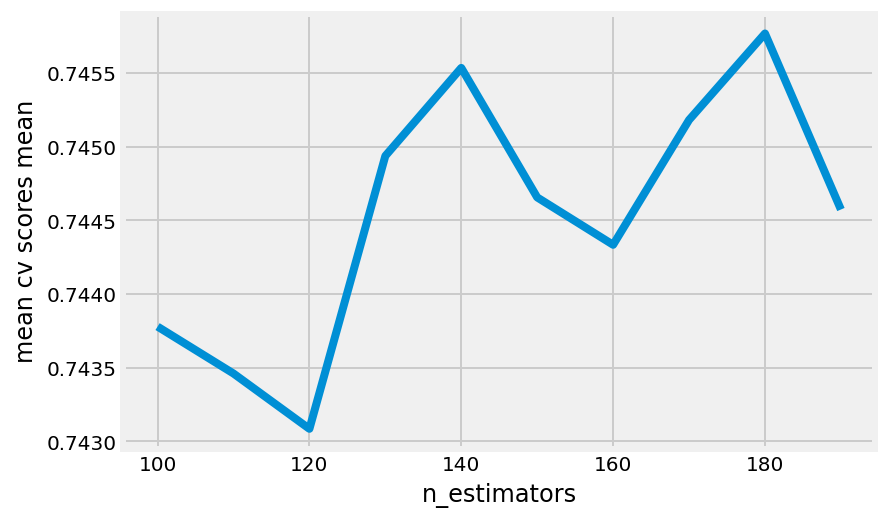

In [79]:
plt.plot(list(range(100,200,10)), lr['mean cv scores mean'])
plt.xlabel('n_estimators')
plt.ylabel('mean cv scores mean');

***Estimator Comparison***

In [103]:
best_models = {'Logistic Regression':LogisticRegression(l1_ratio=0.01, max_iter=10000, penalty='elasticnet',
                                                       solver='saga'),
              'KNN': KNeighborsClassifier(n_neighbors=233),
              'Random Forest': RandomForestClassifier(n_estimators=180, max_features=1.0),
              'Bagging': BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=120,
                                          max_features=0.3, max_samples=0.5),
              'SVC': SVC(C=1, kernel='linear'),
              'AdaBoost': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3),
                                            n_estimators=160, algorithm='SAMME'),
              'Gradient Boosting': GradientBoostingClassifier(learning_rate=0.2, n_estimators=90),
              'MLP': MLPClassifier()}

In [182]:
model = KNeighborsClassifier(n_neighbors=110)

In [213]:
X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=rand)
vect = TfidfVectorizer(stop_words=stopwords_full, max_df=0.3104)
X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

model.fit(X_train, y_train)
predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)


/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cv', 'mean', 'score', 'scores', 'test'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [214]:
print(classification_report(y_train, predictions_train))

              precision    recall  f1-score   support

        east       0.81      0.95      0.87      1127
        west       0.91      0.70      0.79       854

    accuracy                           0.84      1981
   macro avg       0.86      0.83      0.83      1981
weighted avg       0.85      0.84      0.84      1981



In [215]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

        east       0.77      0.95      0.85       385
        west       0.91      0.66      0.77       325

    accuracy                           0.82       710
   macro avg       0.84      0.80      0.81       710
weighted avg       0.83      0.82      0.81       710



In [216]:
y_test = [1 if y == 'east' else 0 for y in y_test]
predictions_test = [1 if y == 'east' else 0 for y in predictions_test]

In [218]:
y_train = [1 if y == 'east' else 0 for y in y_train]
predictions_train = [1 if y == 'east' else 0 for y in predictions_train]

In [217]:
precision_score(y_test, predictions_test, labels=[1,0])

0.7679324894514767

In [219]:
precision_score(y_train, predictions_train, labels=[1,0])

0.8086232980332829

In [109]:
model_comparison = {}

rands = [10,20,30]
vect = TfidfVectorizer(stop_words=stopwords_full, max_df=0.3104)


for mdl in tqdm(best_models):
    
    train_scores = []
    test_scores = []
    cv_scores_means = []
    
    model = best_models[mdl]
    
    for rand in rands:
        
        start = time()
        
        X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=rand)
        
        X_train = vect.fit_transform(X_train)
        X_test = vect.transform(X_test)
        
        model.fit(X_train, y_train)
        
        train = model.score(X_train, y_train)
        test = model.score(X_test, y_test)
        cv = artist_cross_val_score(model, X_train, y_train, train_artists, random_state=rand)
        
        train_scores.append(train)
        test_scores.append(test)
        cv_scores_means.append(cv)
        
        print(rand, mdl, time()-start)
        
    model_comparison[mdl] = [np.mean(train_scores), np.mean(test_scores), np.mean(cv_scores_means)]

  0%|          | 0/8 [00:00<?, ?it/s]/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'skee', 'smif', 'wessun'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


10 Logistic Regression 56.01437306404114
20 Logistic Regression 57.20214509963989


 12%|█▎        | 1/8 [02:52<20:05, 172.19s/it]

30 Logistic Regression 58.971328020095825
10 KNN 3.446526050567627
20 KNN 3.4309308528900146


 25%|██▌       | 2/8 [03:02<12:21, 123.62s/it]

30 KNN 3.408306837081909
10 Random Forest 1031.3833048343658
20 Random Forest 1077.623018026352


 38%|███▊      | 3/8 [57:23<1:28:44, 1064.93s/it]

30 Random Forest 1152.3112173080444
10 Bagging 177.44325804710388
20 Bagging 183.5442979335785


 50%|█████     | 4/8 [1:06:55<1:01:08, 917.09s/it]

30 Bagging 211.10796189308167
10 SVC 74.63648414611816
20 SVC 93.61036801338196


 62%|██████▎   | 5/8 [1:11:00<35:46, 715.35s/it]  

30 SVC 76.37437105178833
10 AdaBoost 295.10150814056396
20 AdaBoost 286.93955302238464


 75%|███████▌  | 6/8 [1:29:58<28:04, 842.03s/it]

30 AdaBoost 555.557256937027
10 Gradient Boosting 321.7509970664978
20 Gradient Boosting 103.17638993263245


 88%|████████▊ | 7/8 [1:38:53<12:30, 750.11s/it]

30 Gradient Boosting 110.71492385864258
10 MLP 701.4483649730682
20 MLP 675.8457667827606


100%|██████████| 8/8 [2:09:05<00:00, 968.23s/it] 

30 MLP 434.7732410430908


In [ ]:
##### after this, find the best model with ngrams(1,2). What to do with max_df? Gridsearch on KNN for max_df? Yeh

In [110]:
sound

In [132]:
model_comp = pd.DataFrame(model_comparison, index=['mean train score',
                'mean test score', 'mean cv scores mean']).T.sort_values('mean cv scores mean', ascending=False)

In [117]:
#model_comp.to_csv('model_comp.csv')

In [119]:
ind = model_comp.index

In [120]:
#model_comp.reset_index(inplace=True)

In [133]:
model_comp

,mean train score,mean test score,mean cv scores mean
MLP,1.000000,0.808347,0.775997
Bagging,0.998492,0.792558,0.767756
AdaBoost,0.998829,0.777720,0.766814
Gradient Boosting,0.979408,0.784495,0.764033
SVC,0.991292,0.804881,0.757377
Random Forest,1.000000,0.778382,0.750382
Logistic Regression,0.954864,0.803956,0.741157
KNN,0.793408,0.774819,0.724909


In [143]:
m = []
s = []
sc = []
for model in best_models:
    m.extend([model]*2)
    s.extend(['mean test score', 'mean cv scores mean'])
    sc.extend([model_comp.loc[model, 'mean test score'], 
              model_comp.loc[model, 'mean cv scores mean']])
    

    
comp = pd.DataFrame([[M,S,SC] for M,S,SC in zip(m,s,sc)], columns=['estimator', 'score type', 'score'])

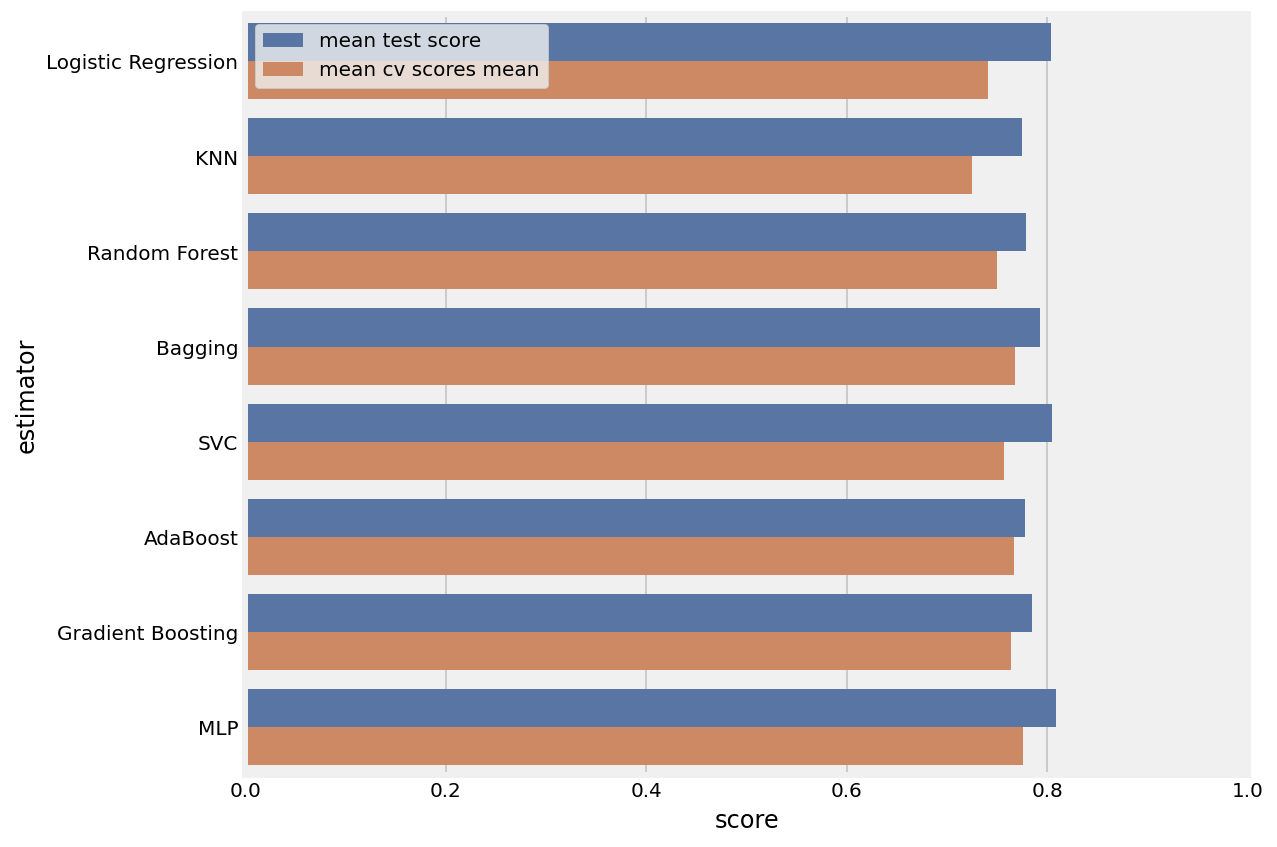

In [343]:
fig,ax = plt.subplots(figsize=(8,7))
sns.barplot(x='score', y='estimator', hue='score type', palette='deep', data=comp, orient='h')
ax.set_xlim(0, 1)
plt.legend(loc=2)
plt.show()
fig.savefig('model_comparison.png', transparent=True, quality=90)

In [346]:
model_comp

,mean train score,mean test score,mean cv scores mean
MLP,1.000000,0.808347,0.775997
Bagging,0.998492,0.792558,0.767756
AdaBoost,0.998829,0.777720,0.766814
Gradient Boosting,0.979408,0.784495,0.764033
SVC,0.991292,0.804881,0.757377
Random Forest,1.000000,0.778382,0.750382
Logistic Regression,0.954864,0.803956,0.741157
KNN,0.793408,0.774819,0.724909


In [347]:
vect = TfidfVectorizer(stop_words=stopwords_full, max_df=0.3104, ngram_range=(1,2))
    
model = best_models['Logistic Regression']

X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=50)

X_train = vect.fit_transform(X_train)
X_test = vect.transform(X_test)

model.fit(X_train, y_train)

predictions_train = model.predict(X_train)
predictions_test = model.predict(X_test)

/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lil', 'lo', 'lot', 'mix', 'one', 'skee'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [335]:
SoundNotification()

In [338]:
feature_importance_dict = {
    feature:[] for feature in range(X_train.shape[1])
}

for n_est in range(120):
    
    for feat,imp in zip(model.estimators_features_[n_est], model.estimators_[n_est].feature_importances_):
        
        if imp > 0:
            feature_importance_dict[feat].append(imp)
            
feature_importance_dict = {
    feature:sum(imps) for feature, imps in zip(feature_importance_dict.keys(), feature_importance_dict.values())
    if sum(imps)>0
}

In [340]:
feat_names = [vect.get_feature_names()[i] for i in feature_importance_dict.keys()]
f_imp = pd.DataFrame(feature_importance_dict.values(), index=feat_names).sort_values(0, ascending=False)

In [344]:
f_imp.sort_values(0, ascending=False).head(30)

,0
homies,3.794353
fool,2.255165
punk,2.082061
word,1.683713
homie,1.620763
god,1.301658
son,1.286454
gangsta,1.023871
mad,0.928044
game,0.864341


In [351]:
SoundNotification()

In [348]:
words = vect.get_feature_names()

In [349]:
df_coef = pd.DataFrame(model.coef_, columns=words, index=['coefficients']).T
df_coef['abs'] = df_coef.coefficients.abs()

top_30 = df_coef.sort_values('abs', ascending=False).head(30)

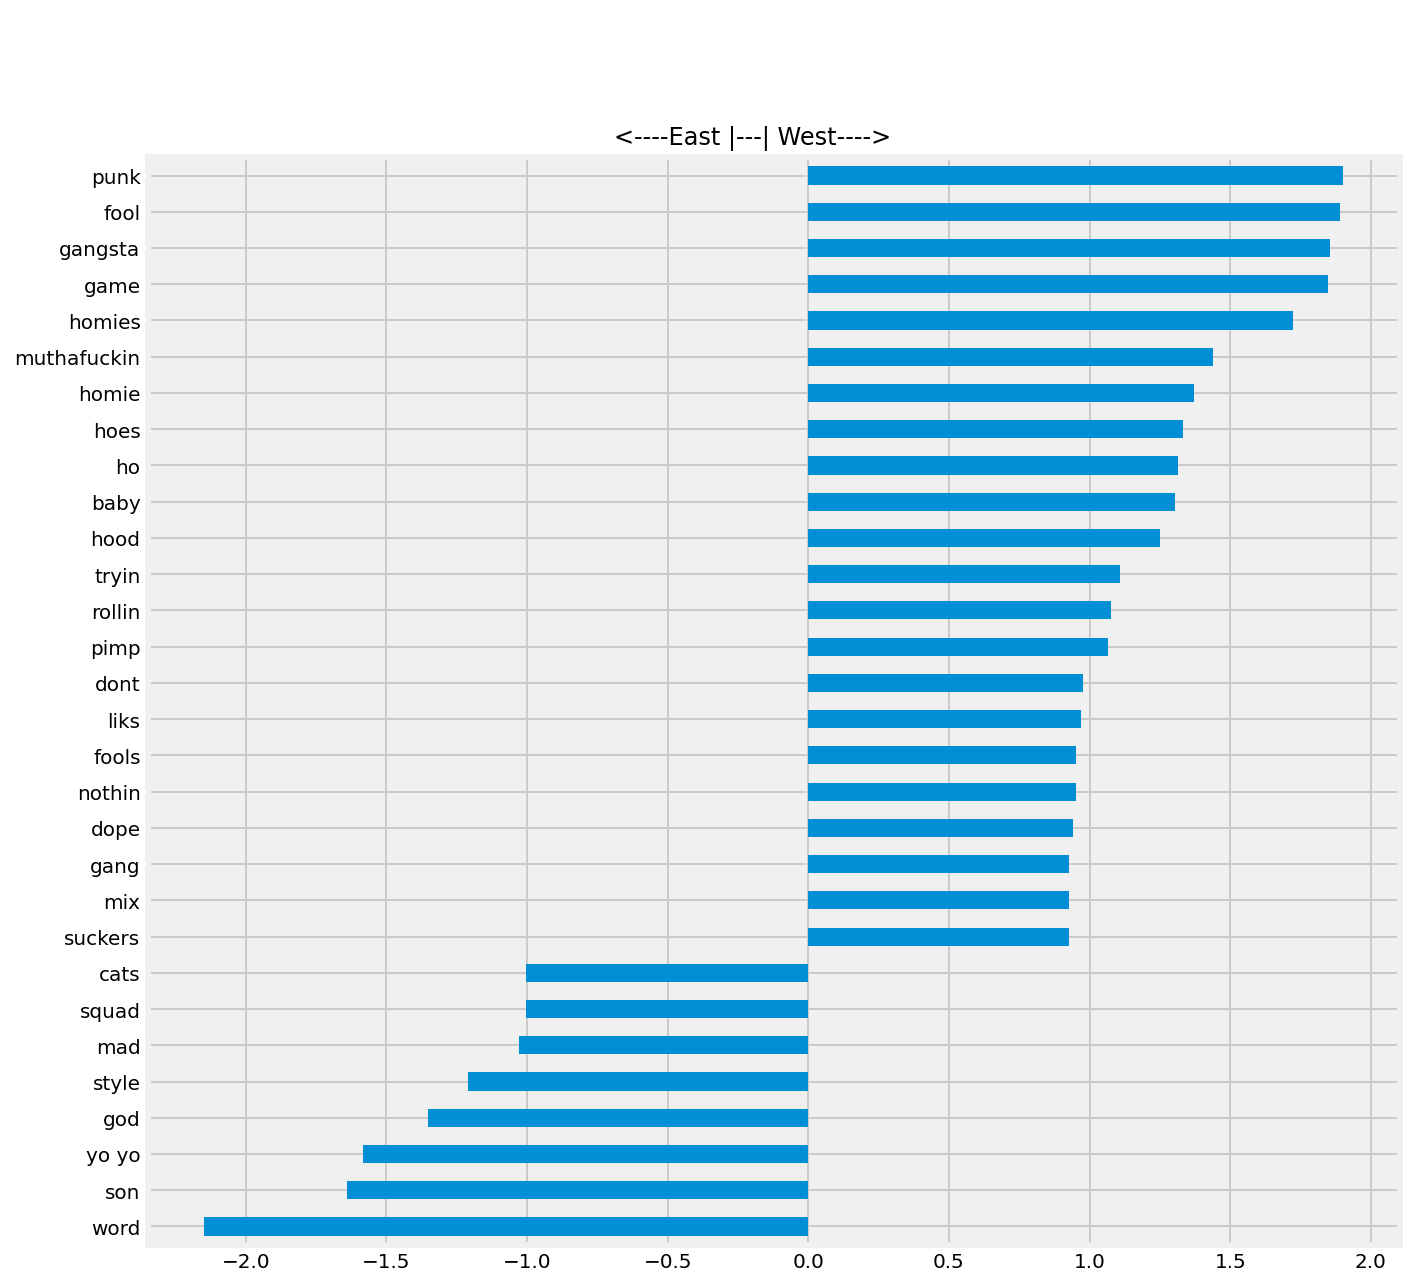

In [353]:
fig, ax = plt.subplots(figsize = (10,10))
top_30['coefficients'].sort_values().plot(kind='barh')
plt.suptitle('\n\n\n\n<----East |---| West---->')
fig.savefig('coef.png', transparent=True);

In [285]:
words_east = list(df_coef.sort_values('coefficients').index)[:100]
freq_east = list(df_coef.sort_values('coefficients')['abs'])[:100]
words_west = list(df_coef.sort_values('coefficients', ascending=False).index)[:100]
freq_west = list(df_coef.sort_values('coefficients', ascending=False)['abs'])[:100]

In [286]:
freq_east = [round(f*1000000) for f in freq_east]
freq_west = [round(f*1000000) for f in freq_west]

In [293]:
east = pd.DataFrame(freq_east, index=words_east, columns=['frequency'])
west = pd.DataFrame(freq_west, index=words_west, columns=['frequency'])

In [315]:
west.iloc[:30]
# 'lil dap', 'dap', 'wessun', 'smif', 'doc', 'shaolin', 'jamar', 'jam', 'smif wessun', 'ricky', 'buddha',
# 'loc', 'donald', 'eihthype'




# muthafuckin

,frequency
punk,1897953
fool,1883289
gangsta,1851277
game,1846714
homies,1717692
muthaf****n,1426466
homie,1363363
h**s,1332958
h*,1312648
baby,1301676


In [316]:
def to_wordcloud(word_frequency_matrix, n_words):
    
    words = list(word_frequency_matrix.index)[:n_words]
    frequencies = list(word_frequency_matrix.frequency)[:n_words]

    
    return {word:freq for word,freq in zip(words, frequencies)}

In [317]:
def grey_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    return "hsl(0, 0%%, %d%%)" % random.randint(98, 100)

In [318]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from PIL import Image

In [329]:
pic = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery/4656.jpg',stream=True).raw))

inverse_pic = np.array([[[1-k for k in j] for j in i] for i in pic])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='blue', colormap='Pastel1',
                mask = inverse_pic,
                min_font_size = 10).generate_from_frequencies(to_wordcloud(east, 500))

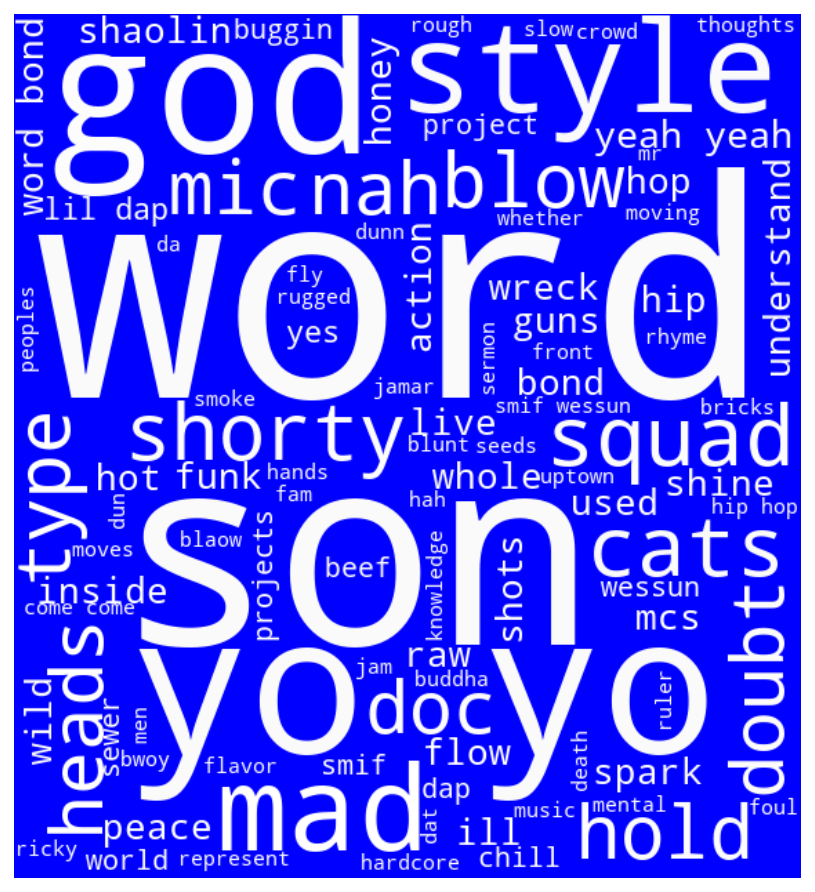

In [330]:
fig = plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
fig.savefig('east_cloud.png', transparent=True)

In [331]:
pic = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery/4656.jpg',stream=True).raw))

inverse_pic = np.array([[[1-k for k in j] for j in i] for i in pic])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='red', colormap='Pastel1',
                mask = inverse_pic,
                min_font_size = 10).generate_from_frequencies(to_wordcloud(west, 500))

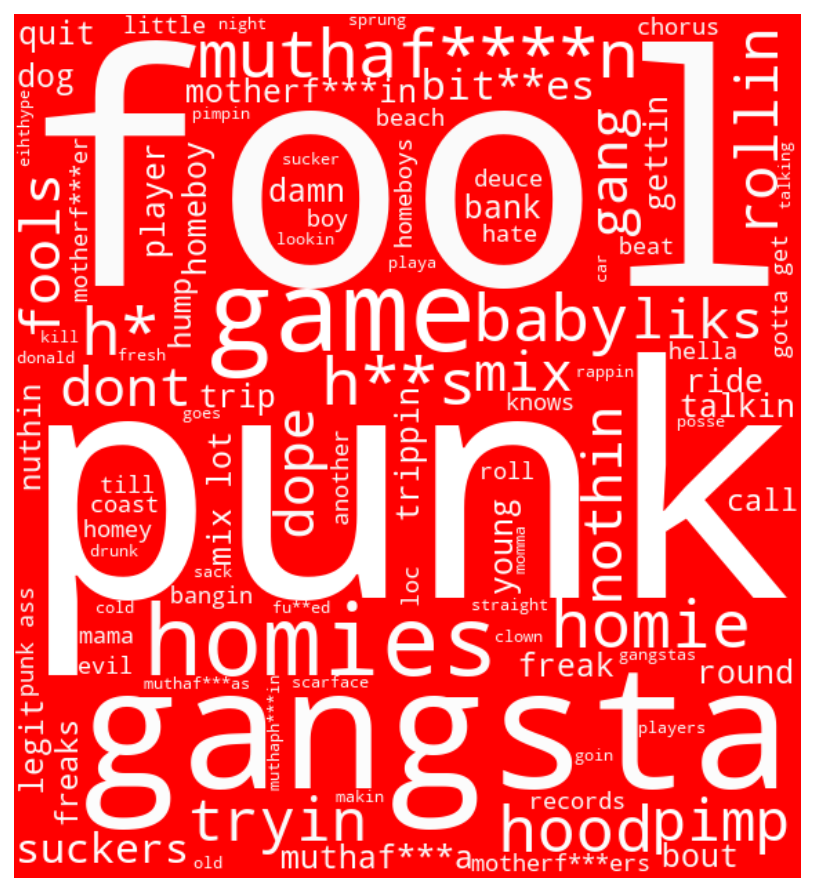

In [333]:
fig = plt.figure(figsize = (6, 6), facecolor = 'white', edgecolor='blue')
plt.imshow(wordcloud.recolor(color_func=grey_color_func, random_state=3),
           interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad = 0)
  
plt.show()
fig.savefig('west_cloud.png', transparent=True)

In [225]:
predictions_test = [1 if p=='east' else 0 for p in predictions_test]
predictions_train = [1 if p=='east' else 0 for p in predictions_train]

In [226]:
y_train = [1 if p=='east' else 0 for p in y_train]
y_test = [1 if p=='east' else 0 for p in y_test]

In [229]:
print(classification_report(y_test, predictions_test))

              precision    recall  f1-score   support

           0       0.83      0.60      0.70       279
           1       0.77      0.92      0.83       400

    accuracy                           0.79       679
   macro avg       0.80      0.76      0.77       679
weighted avg       0.79      0.79      0.78       679



***Investigate the best model.***

*With this best model, I think you run tonnes of cross vals with different random states, and collect which artists are classified as what. Do I use the test predictions or the cross-val predictions? Probs just go for the test predictions, no reason not to...*

In [76]:
artist_classification = {
    


In [ ]:
for rand in rands:  

In [38]:
X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=10)

In [39]:
vec = TfidfVectorizer(stop_words=stopwords_full, max_df=0.3104)
vec = vec.fit(X_train)

/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'skee', 'smif', 'wessun'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [45]:
scores = []

for r in range(1,10,2):

    X_train, X_test, y_train, y_test, train_artists = artist_train_test_split(random_state=r)

    vec = TfidfVectorizer(stop_words=stopwords_full, max_df=0.3104)
    vec = vec.fit(X_train)

    X_train, X_test = vec.transform(X_train), vec.transform(X_test)

    scores.append(artist_cross_val_score(model, X_train, y_train, train_artists))

/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'skee', 'smif', 'wessun'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'skee', 'smif', 'wessun'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '
/Users/georgerolls/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['krs', 'legit', 'lo', 'lot', 'mix', 'one', 'ske

In [49]:
[np.mean(score) for score in scores]
##### not great..........
# just a fluke with the random state.

[0.7662486919640827,
 0.7709603683454199,
 0.7671893237125991,
 0.7635196095112493,
 0.7620353535275681]

In [ ]:
####

In [41]:
model = BaggingClassifier(base_estimator=DecisionTreeClassifier(), max_features=0.3,
                         max_samples=0.5, n_estimators=150, random_state=1)

In [42]:
artist_cross_val_score(model, X_train, y_train, train_artists)

[0.84,
 0.8156028368794326,
 0.7917737789203085,
 0.6953316953316954,
 0.8119891008174387]

In [44]:
np.mean([0.84,
 0.8156028368794326,
 0.7917737789203085,
 0.6953316953316954,
 0.8119891008174387])

0.7909394823897751

In [46]:
#sound = SoundNotification()
sound

In [26]:
len(model.estimators_[2].feature_importances_)

10181

In [27]:
model.estimators_[0].n_features_/0.3, X_train.shape[1]

(33936.66666666667, 33938)

In [28]:
feature_importance_dict = {
    feature:[] for feature in range(X_train.shape[1])
}

for n_est in range(150):
    
    for feat,imp in zip(model.estimators_features_[n_est], model.estimators_[n_est].feature_importances_):
        
        if imp > 0:
            feature_importance_dict[feat].append(imp)
            
    

In [29]:
feature_importance_dict = {
    feature:sum(imps) for feature, imps in zip(feature_importance_dict.keys(), feature_importance_dict.values())
    if sum(imps)>0
}

In [30]:
feat_names = [vec.get_feature_names()[i] for i in feature_importance_dict.keys()]
f_imp = pd.DataFrame(feature_importance_dict.values(), index=feat_names).sort_values(0, ascending=False)

,0
homies,4.518315
bitch,3.655934
fool,3.528274
punk,2.758715
word,2.719548


In [34]:
f_imp.sort_values(0, ascending=False).head(30)

,0
homies,4.518315
bitch,3.655934
fool,3.528274
punk,2.758715
word,2.719548
homie,2.233876
fools,2.046407
hoes,1.953759
rollin,1.058385
hood,0.931082


In [31]:
sound